# Homework 3 - Question 3 - Luke Arend

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft, fftshift
from scipy.io import loadmat
from scipy.signal import convolve, resample

Neuronal activity causes local changes in deoxyhemoglobin concentration in the blood, which can be measured using functional magnetic resonance imaging (fMRI). One drawback of fMRI is that the haemodynamic response (blood flow in response to neural activity) is much slower than the underlying neural responses. We can model the delay and spread of the measurements relative to the neural signals using a linear shift-invariant system

$r(n) = \sum_k{x(n − k)h(k)}$,

where $x(n)$ is an input signal delivered over time (for example, a sequence of light intensities), $h(k)$ is the haemodynamic response to a single light flash at time $k = 0$ (i.e., the impulse response of the MRI measurement), and $r(n)$ is the MRI response to the full input signal.

In the file `hrfDeconv.mat`, you will find a response vector $r$ and an input vector $x$ containing a sequence of impulses (indicating flashes of light). Your goal is to estimate the HRF, $h$, from the data. Each of these signals are sampled at 1 Hz.

In [2]:
obj = loadmat('hw3/hrfDeconv.mat')
x = np.squeeze(obj['x'])
r = np.squeeze(obj['r'])

Plot vectors $r$ and $x$ versus time to get a sense for the data. Use the `stem` command (or `plt.stem` in Python) for $x$, and label the x-axis.

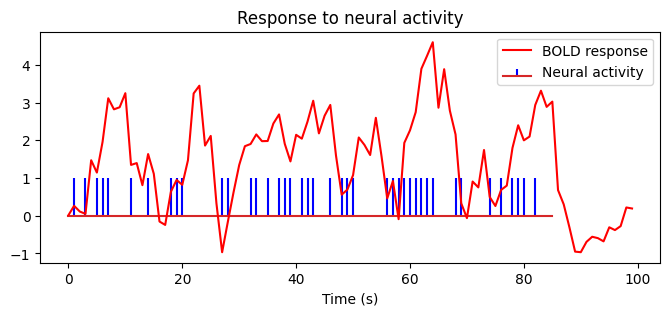

In [3]:
plt.subplots(figsize=(8, 3))
plt.title('Response to neural activity')
plt.stem(x, 'b', label='Neural activity', markerfmt='')
plt.plot(r, 'r', label='BOLD response')
plt.xlabel('Time (s)')
plt.legend()
plt.show()

# a)

Convolution is linear, and thus we can re-write the equation above as a matrix multiplication, $r = Xh$, where $h$ is a vector of length $M$, $N$ is the length of the input $x$, and $X$ is an $[N + M − 1] × M$ matrix. Write a function `createConvMat`, that takes as arguments an input vector $x$ and $M$ (the dimensionality of $h$) and generates a matrix $X$ such that the response $r = Xh$ is as defined in Eq. (1) for any $h$.

In [4]:
def create_conv_mat(x, M):
    N = len(x)
    X = np.zeros((N + M - 1, M))
    padding = np.zeros(M - 1)
    x_padded = np.concatenate([padding, x, padding])
    for i in range(N + M - 1):
        X[i, :] = x_padded[i:i + M][::-1]
    return X

Verify that the matrix generated by your function produces the same response as Matlab’s `conv` function when applied to a few random $h$ vectors of length $M = 15$.

In [5]:
X = create_conv_mat(x, 15)
for i in range(3):
    h = np.random.randn(15)
    ok = np.allclose(X @ h, convolve(h, x))
    print(ok)

True
True
True


Visualize the matrix $X$ as an image (evaluate `imagesc(X)` in MATLAB or `plt.imshow` in Python), and describe its structure.

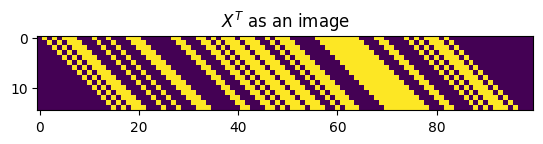

In [6]:
plt.title('$X^T$ as an image')
plt.imshow(X.T)
plt.show()

I plotted $X^T$ since it fits on the page better. The columns in the image above are the rows of $X$.

The rows of $X$ are views of $x$ through a sliding window of size 15. The first window overlaps with just the first value of $x$ and sees 14 zeros to the left of it. The window takes steps of size 1 along $x$ from left to right. The last window overlaps with just the last value of $x$ and sees 14 zeros to the right of it.

# b)

Now, given the $X$ generated by your function for $M = 15$, solve for $h$ by formulating a least-squares regression problem:

$h_{opt} = \text{argmin}_h \rVert r−Xh \lVert^2$.

As we saw in class, if $X$ has the singular value decomposition $X = U S V^T$, then the $\beta_{opt}$ which minimizes $\rVert y−X\beta \lVert^2$ is $V S^\sharp U^T y$, where $S^\sharp$ is the pseudoinverse of $S.$ So in our case,

$h_{opt} = V S^\sharp U^T r$.

In [7]:
U, s, Vt = np.linalg.svd(X)
s

array([17.63933449,  6.43899633,  5.77725291,  5.57980237,  5.29411603,
        5.28811517,  5.08114521,  5.07735029,  5.00764389,  4.34175081,
        4.16739293,  3.84902884,  3.68032107,  2.81980577,  2.77262653])

In [8]:
Vt.shape, U.shape

((15, 15), (100, 100))

In [9]:
padding = np.zeros((len(Vt), len(U) - len(s)))
s_sharp = np.concatenate([np.diag(1 / s), padding], axis=1)
h_opt = Vt.T @ s_sharp @ U.T @ r
h_opt

array([ 0.08038615,  0.20651242,  0.54851395,  0.98458329,  1.09930568,
        0.98008733,  0.35467779,  0.07621158,  0.03380402, -0.10810732,
       -0.40934496, -0.0687829 , -0.27365116, -0.22476736,  0.09256217])

Plot $h_{opt}$ as a function of time (label your x-axis, including units). How would you describe it? How long does it last?

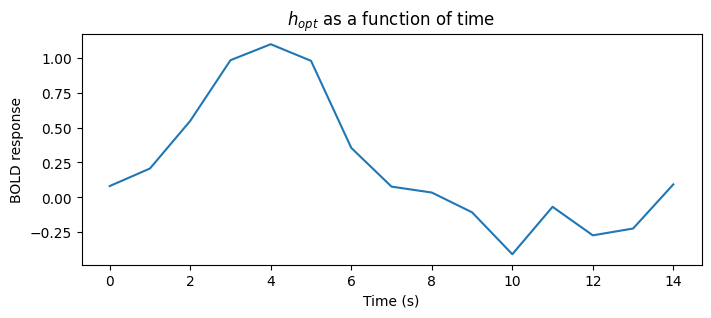

In [10]:
plt.subplots(figsize=(8, 3))
plt.title('$h_{opt}$ as a function of time')
plt.plot(h_opt)
plt.xlabel('Time (s)')
plt.ylabel('BOLD response')
plt.show()

The hemodynamic response ramps up over the first few seconds, reaching a maximum around 1.0 at 4 seconds after stimulus onset, and then ramps back down over the next 6 seconds, reaching a minimum around -0.25 at t = 10. The total response **lasts 15 seconds**.

# c)

It’s often easier to understand an LSI system by viewing it in the frequency domain. Plot the power-spectrum of the HRF (i.e. $\vert F(h) \rvert^2$, where $F(h)$ is the Fourier transform of the HRF). Plot this with the zero frequency (DC) in the middle (in Matlab you can use a built-in function called `fftshift`), and label the x axis, in Hz.

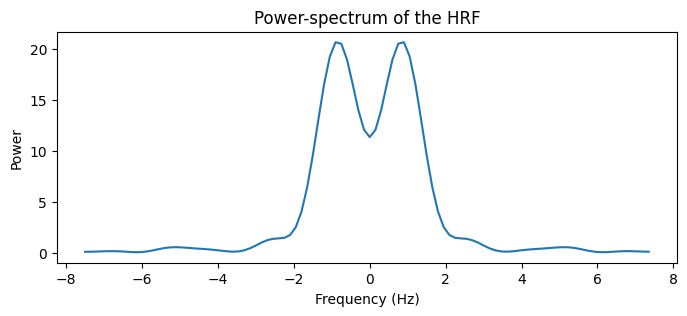

In [11]:
nbins = 100
n = np.arange(nbins) - 50
freqs = len(h_opt) / 100 * n
h_fft = fft(h_opt, n=nbins)
power = np.abs(h_fft) ** 2
plt.subplots(figsize=(8, 3))
plt.title('Power-spectrum of the HRF')
plt.plot(freqs, fftshift(power))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.show()

Based on this plot, what kind of filter is the HRF? Specifically, which frequencies does it allow to pass, and which does it block?

The HRF is a kind of low-frequency bandpass filter that favors frequencies around 1 Hz and DC signals to some extent. It strongly attenuates 2 Hz and almost completely blocks frequencies 3 Hz and higher.

# d)

Use the convolution theorem to now find $h_{opt}$ by working in the Fourier domain. You will need to use the matlab functions `fft` and `ifft`. Remember to be careful about how many samples you choose to have in your `fft`.

The convolution theorem says that if $f = \mathcal{F}(x)$ and $g = \mathcal{F}(y)$ then $\mathcal{F}(x * y) = f \odot g$, where $*$ denotes convolution and $\odot$ denotes elementwise multiplication. Or in our case,

$\mathcal{F}(x * h) = \mathcal{F}(r) = \mathcal{F}(x) \odot \mathcal{F}(h)$

We can get $\mathcal{F}(h)$ by taking $\mathcal{F}(r)$ elementwise divided by $\mathcal{F}(x)$, and get $h$ by taking the inverse Fourier transform of $\mathcal{F}(h)$.

In [12]:
def fourier_solve(x, r, nbins):
    r_fft = fft(r, n=nbins)
    x_fft = fft(x, n=nbins)
    window = np.abs(len(x) - len(r)) + 1
    return ifft(r_fft / x_fft, n=nbins)[:window]
    
h_opt2 = np.real(fourier_solve(x, r, nbins=86 * 100))
h_opt2

array([-0.07660524,  0.03939486,  0.52864874,  0.99800785,  1.0947841 ,
        1.02850338,  0.39444263, -0.05186693,  0.15348495, -0.22611325,
       -0.49428447, -0.05086755, -0.50811995, -0.33690616,  0.14311   ])

Based on the operations you have done, what can you say about when this method will fail?

This method reconstructs $h_{opt}$ with better precision as the Fourier `nbins` grows. Also, due to Fourier resampling, the best reconstructions occur when `nbins` is a multiple of the lengths of `x` and `r`. The reconstruction degrades as `nbins` decreases and a full signal **cannot be constructed if `nbins` is less than 15**.

On the same graph, plot the HRF impulse response you recovered from parts (c) and (d).

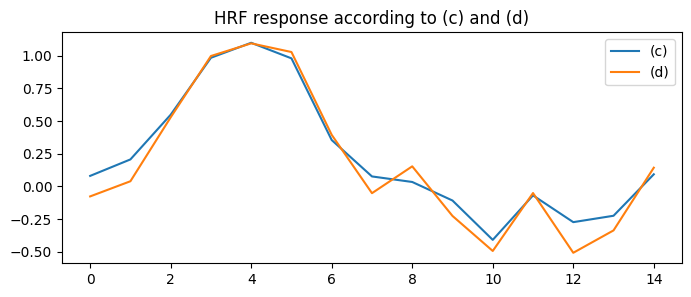

In [13]:
plt.subplots(figsize=(8, 3))
plt.title('HRF response according to (c) and (d)')
plt.plot(h_opt, label='(c)')
plt.plot(h_opt2, label='(d)')
plt.legend()
plt.show()